
# ARIMA and Seasonal ARIMA


## Autoregressive Integrated Moving Averages

The general process for ARIMA models is the following:
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model
* Use the model to make predictions

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df= pd.read_csv(r'C:\Users\Pavlo\Documents\Raw Algo Trading\08-Time-Series-Analysis\monthly-milk-production-pounds-p.csv')
df.columns = ['Month', 'Milk in Pounds per Cow']
df.drop(168,axis=0,inplace=True)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
df.head()

,Milk in Pounds per Cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk in Pounds per Cow,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


**Visualize the Time Series Data**

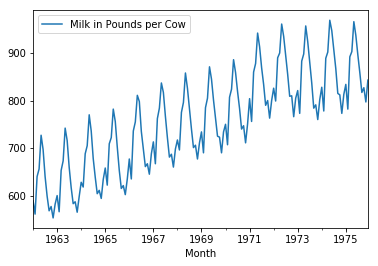

In [4]:
df.plot()

Can confirm it has a trend and seasonal aspect

In [5]:
time_series = df['Milk in Pounds per Cow']
type(time_series)

pandas.core.series.Series

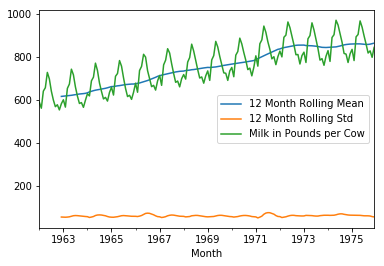

In [6]:
time_series.rolling(12).mean().plot(label='12 Month Rolling Mean')
time_series.rolling(12).std().plot(label='12 Month Rolling Std')
time_series.plot()
plt.legend()

**Decomposition**
    ETS decomposition allows us to see the individual parts!

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

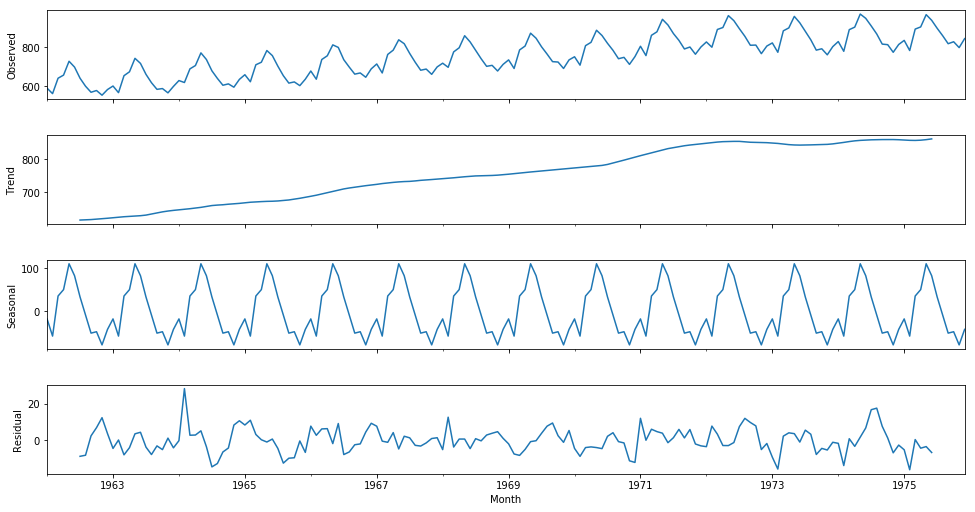

In [8]:
decomp = seasonal_decompose(time_series)
fig = decomp.plot()
fig.set_size_inches(15,8)

## Testing for Stationarity

We can use the Augmented [Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) [unit root test](https://en.wikipedia.org/wiki/Unit_root_test).

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Basically, we are trying to whether to accept the Null Hypothesis **H0** (that the time series has a unit root, indicating it is non-stationary) or reject **H0** and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

We end up deciding this based on the p-value return.

* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

Let's run the Augmented Dickey-Fuller test on our data:

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
result = adfuller(df['Milk in Pounds per Cow'])
result

(-1.3038115874221317,
 0.6274267086030305,
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1115.1730447395112)

In [11]:
def adf_check(time_series):
    result = adfuller(time_series)
    print('Augmented Dicky-Fuller Test')
    labels = ['ADF Test Statistic', 'p-value', '# of lags','Num of Observations used']
    
    for value,label in zip(result,labels):
        print(label+ " : "+str(value))
        
    if result[1] <= 0.05:
        print('Strong evidence against null hypothesis')
        print('Reject null hypothesis')
        print('Data has no unit root and is stationary')
    else:
        print('Weak evidence against null hypothesis')
        print('Fail to reject null hypothesis')
        print('Data has a unit root, it is non-stationary')

In [12]:
adf_check(df['Milk in Pounds per Cow'])

Augmented Dicky-Fuller Test
ADF Test Statistic : -1.3038115874221317
p-value : 0.6274267086030305
# of lags : 13
Num of Observations used : 154
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root, it is non-stationary


Since it is non-stationary we will difference the data


## Important Note!

** We have now realized that our data is seasonal (it is also pretty obvious from the plot itself). This means we need to use Seasonal ARIMA on our model. If our data was not seasonal, it means we could use just ARIMA on it. We will take this into account when differencing our data! Typically financial stock data won't be seasonal, but that is kind of the point of this section, to show you common methods, that won't work well on stock finance data!**

_____

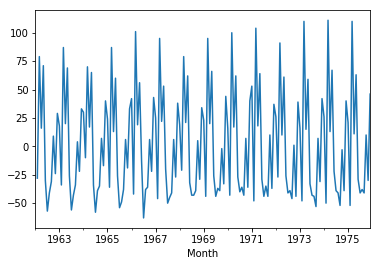

In [13]:
df['First Difference'] = df['Milk in Pounds per Cow'] - df['Milk in Pounds per Cow'].shift(1)
df['First Difference'].plot()

In [14]:
adf_check(df['First Difference'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic : -3.0549955586530895
p-value : 0.030068004001784086
# of lags : 14
Num of Observations used : 152
Strong evidence against null hypothesis
Reject null hypothesis
Data has no unit root and is stationary


Lets assume the first difference wasn't enough

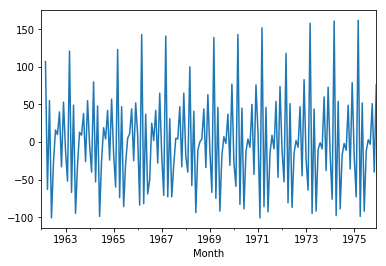

In [15]:
df['Second Difference'] = df['First Difference'] - df['First Difference'].shift(1)
df['Second Difference'].plot()

In [16]:
adf_check(df['Second Difference'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic : -14.327873645603342
p-value : 1.1126989332082822e-26
# of lags : 11
Num of Observations used : 154
Strong evidence against null hypothesis
Reject null hypothesis
Data has no unit root and is stationary


Seasonal Difference

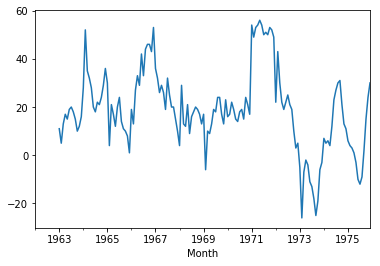

In [17]:
#Shifting it an entire season
df['Seasonal Difference'] = df['Milk in Pounds per Cow'] - df['Milk in Pounds per Cow'].shift(12)
df['Seasonal Difference'].plot()

In [18]:
adf_check(df['Seasonal Difference'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic : -2.335419314359397
p-value : 0.16079880527711382
# of lags : 12
Num of Observations used : 143
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root, it is non-stationary


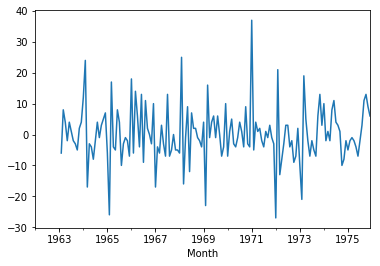

In [19]:
df['Seasonal First Difference'] = df['First Difference'] - df['First Difference'].shift(12)
df['Seasonal First Difference'].plot()

In [20]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic : -5.03800227492198
p-value : 1.865423431878859e-05
# of lags : 11
Num of Observations used : 143
Strong evidence against null hypothesis
Reject null hypothesis
Data has no unit root and is stationary


# Autocorrelation and Partial Autocorrelation Plots

An autocorrelation plot (also known as a [Correlogram](https://en.wikipedia.org/wiki/Correlogram) ) shows the correlation of the series with itself, lagged by x time units. So the y axis is the correlation and the x axis is the number of time units of lag.

So imagine taking your time series of length T, copying it, and deleting the first observation of copy #1 and the last observation of copy #2. Now you have two series of length T−1 for which you calculate a correlation coefficient. This is the value of of the vertical axis at x=1x=1 in your plots. It represents the correlation of the series lagged by one time unit. You go on and do this for all possible time lags x and this defines the plot.

You will run these plots on your differenced/stationary data. There is a lot of great information for identifying and interpreting ACF and PACF [here](http://people.duke.edu/~rnau/arimrule.htm) and [here](https://people.duke.edu/~rnau/411arim3.htm).

### Autocorrelation Interpretation

The actual interpretation and how it relates to ARIMA models can get a bit complicated, but there are some basic common methods we can use for the ARIMA model. Our main priority here is to try to figure out whether we will use the AR or MA components for the ARIMA model (or both!) as well as how many lags we should use. In general you would use either AR or MA, using both is less common.

* If the autocorrelation plot shows positive autocorrelation at the first lag (lag-1), then it suggests to use the AR terms in relation to the lag

* If the autocorrelation plot shows negative autocorrelation at the first lag, then it suggests using MA terms.

### <font color='red'> Important Note! </font> 

Here we will be showing running the ACF and PACF on multiple differenced data sets that have been made stationary in different ways, typically you would just choose a single stationary data set and continue all the way through with that.

The reason we use two here is to show you the two typical types of behaviour you would see when using ACF.
_____

In [21]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

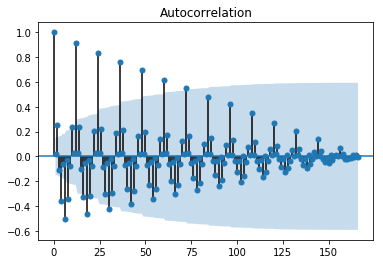

In [22]:
# Duplicate plots
# Check out: https://stackoverflow.com/questions/21788593/statsmodels-duplicate-charts
# https://github.com/statsmodels/statsmodels/issues/1265
fig_first = plot_acf(df["First Difference"].dropna())

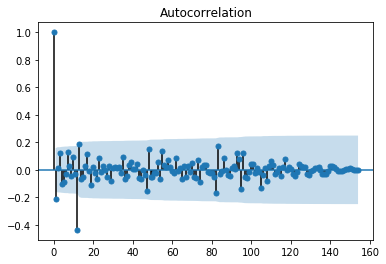

In [23]:
fig_seasonal_first = plot_acf(df["Seasonal First Difference"].dropna())

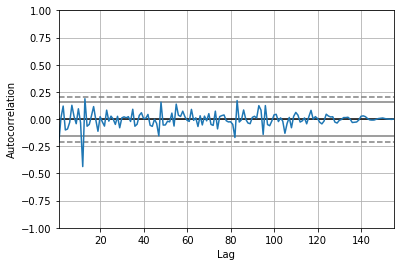

In [24]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Seasonal First Difference'].dropna())

## Partial Autocorrelation

In general, a partial correlation is a conditional correlation.

It is the correlation between two variables under the assumption that we know and take into account the values of some other set of variables.

For instance, consider a regression context in which y = response variable and x1, x2, and x3 are predictor variables.  The partial correlation between y and x3 is the correlation between the variables determined taking into account how both y and x3 are related to x1 and x2.

Formally, this is relationship is defined as:

## $\frac{\text{Covariance}(y, x_3|x_1, x_2)}{\sqrt{\text{Variance}(y|x_1, x_2)\text{Variance}(x_3| x_1, x_2)}}$

Check out this [link](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm) for full details on this.

C:\Users\Pavlo\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


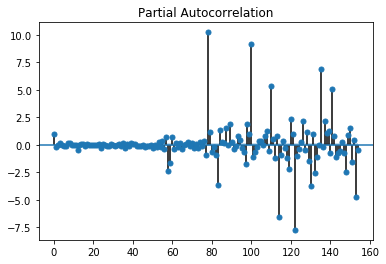

In [25]:
#Yo this graph is fucked up.
result = plot_pacf(df["Seasonal First Difference"].dropna())

**The other one in vid looked like this:

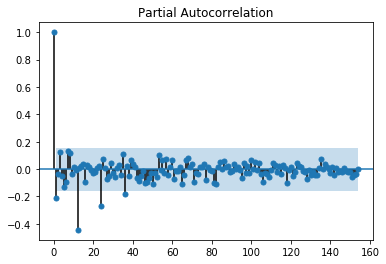

### Interpretation

Typically a sharp drop after lag "k" suggests an AR-k model should be used. If there is a gradual decline, it suggests an MA model.

### Final Thoughts on Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.

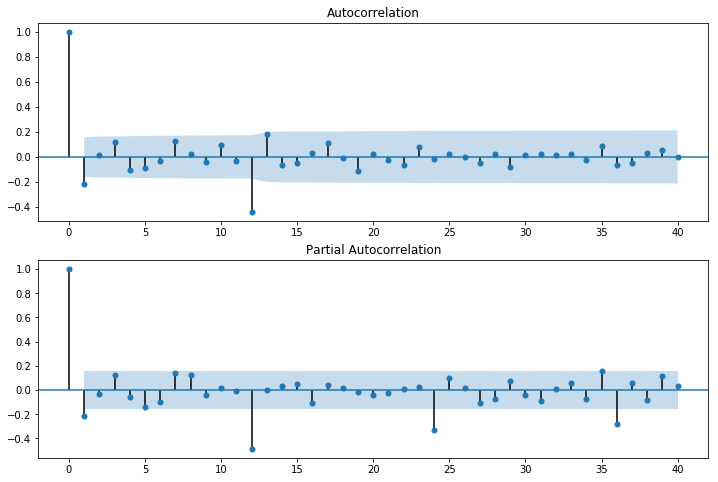

In [26]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax2)

In [27]:
# For non-seasonal data
from statsmodels.tsa.arima_model import ARIMA

### p,d,q parameters

* p: The number of lag observations included in the model.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

In [28]:
# We have seasonal data!
model = sm.tsa.statespace.SARIMAX(df['Milk in Pounds per Cow'],order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:             Milk in Pounds per Cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Sat, 29 Jun 2019   AIC                           1074.131
Time:                                    07:58:34   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

C:\Users\Pavlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Pavlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


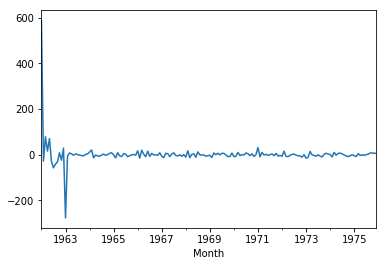

In [29]:
#Showing all the erros it made
results.resid.plot()

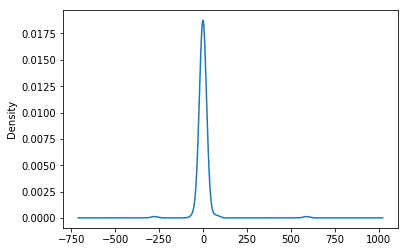

In [30]:
#The close to zero the better
results.resid.plot(kind='kde')

## Prediction of Future Values

Firts we can get an idea of how well our model performs by just predicting for values that we actually already know:

C:\Users\Pavlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


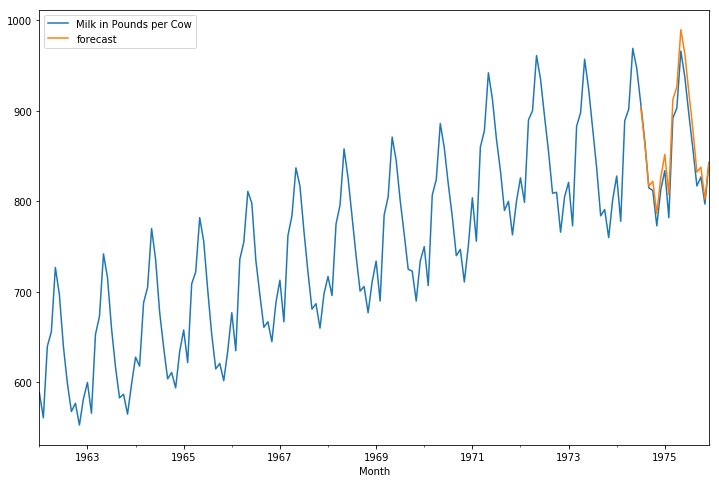

In [31]:
df['forecast'] = results.predict(start = 150, end= 168, dynamic= True)  
df[['Milk in Pounds per Cow','forecast']].plot(figsize=(12,8))

In [32]:
df.tail()

,Milk in Pounds per Cow,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,forecast
Month,,,,,,
1975-08-01,858.0,-38.0,3.0,-9.0,3.0,879.668975
1975-09-01,817.0,-41.0,-3.0,2.0,11.0,832.328555
1975-10-01,827.0,10.0,51.0,15.0,13.0,837.722251
1975-11-01,797.0,-30.0,-40.0,24.0,9.0,802.452738
1975-12-01,843.0,46.0,76.0,30.0,6.0,842.499871


In [33]:
#We need to add in more months to our data set
from pandas.tseries.offsets import DateOffset

In [34]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1,24)]
future_dates

[Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00')]

In [35]:
future_df = pd.DataFrame(index=future_dates,columns=df.columns)
future_df

,Milk in Pounds per Cow,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1976-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-02-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-03-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-04-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-05-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-06-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-08-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-09-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-10-01,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
#Combining the original df with the one we just created
final_df = pd.concat([df,future_df])

In [37]:
final_df['forecast'] = results.predict(start=168,end=192)
final_df.tail()

,Milk in Pounds per Cow,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1977-07-01,NaN,NaN,NaN,NaN,NaN,951.525867
1977-08-01,NaN,NaN,NaN,NaN,NaN,911.918957
1977-09-01,NaN,NaN,NaN,NaN,NaN,865.881182
1977-10-01,NaN,NaN,NaN,NaN,NaN,871.027296
1977-11-01,NaN,NaN,NaN,NaN,NaN,836.962996


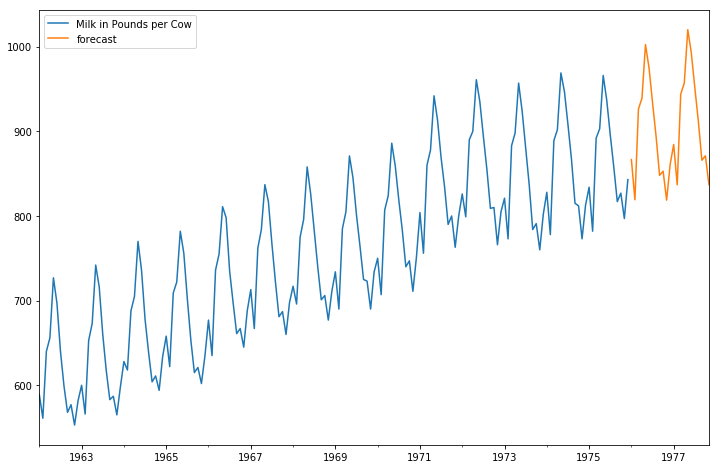

In [38]:
final_df[['Milk in Pounds per Cow', 'forecast']].plot(figsize=(12, 8))

For resources for choosing the PDQ, check out the reading here 

Full Book Chapter on this:

https://people.duke.edu/~rnau/arimrule.htm

Nice example:

https://stats.stackexchange.com/questions/44992/what-are-the-values-p-d-q-in-arima